# Model Training with LSTM Autoencoder

Model trained with the data which is manually numerized and trained with the data vectorized with word2vec algorithm.

<li> Model trained with the data numerized
<li> Model trained with the data vectorized

## Model trained with the data numerized

### Loading the data:

* Firstly we are importing and downloading necesarry files.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf #for machine learning and ai generating

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler #machine learning, z=X-μ/σ, Xscaled= Xmax−Xmin / X−Xmin
from tensorflow.keras.models import Sequential, Model #ai, Sequential is the simplest way to build neural networks
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout, RepeatVector, TimeDistributed #LSTM:memory algo, dense: fully connecting layers, dropout: regularization technique, repeatvectore:Repeats the input vector to create a sequence

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt # visualization

In [ ]:
# Dictionary with dataset names and their raw GitHub URLs
datasets = {
    "TrainSet": "https://raw.githubusercontent.com/sabisay/AnomalyDetectionOnLogDatas/refs/heads/main/DatasetsAfterPreprocess/df_train.csv",
    "CVSet": "https://raw.githubusercontent.com/sabisay/AnomalyDetectionOnLogDatas/refs/heads/main/DatasetsAfterPreprocess/df_cv.csv",
    "TestSet": "https://raw.githubusercontent.com/sabisay/AnomalyDetectionOnLogDatas/refs/heads/main/DatasetsAfterPreprocess/df_test.csv",
}

# Load datasets seperately
df_train = pd.read_csv(datasets["TrainSet"])
df_cv = pd.read_csv(datasets["CVSet"])
df_test = pd.read_csv(datasets["TestSet"])

In [ ]:
datasets_2 = {
    "cv_labeled" : "https://raw.githubusercontent.com/sabisay/AnomalyDetectionOnLogDatas/refs/heads/main/DatasetsAfterPreprocess/df_labeled_cv.csv",
    "test_labeled" : "https://raw.githubusercontent.com/sabisay/AnomalyDetectionOnLogDatas/refs/heads/main/DatasetsAfterPreprocess/df_labeled_test.csv"
}

df_cv_labeled = pd.read_csv(datasets_2["cv_labeled"])
df_test_labeled = pd.read_csv(datasets_2["test_labeled"])



*   Bcs of LSTM learns from differentiation in time we need to sort the data


In [ ]:
df_train_sorted = df_train.sort_values(by="Timestamp").reset_index(drop=True)
df_cv_sorted = df_cv.sort_values(by="Timestamp").reset_index(drop=True)
df_test_sorted = df_test.sort_values(by="Timestamp").reset_index(drop=True)
df_labeled_cv_sorted = df_cv_labeled.sort_values(by="Timestamp").reset_index(drop=True)
df_labeled_test_sorted = df_test_labeled.sort_values(by="Timestamp").reset_index(drop=True)



*   Applyin normalization

In [ ]:
# Assuming 'Timestamp' is the datetime column
datetime_cols = ['Timestamp']

# Convert datetime columns to numerical representation (e.g., Unix timestamp)
for col in datetime_cols:
    df_train_sorted[col] = pd.to_datetime(df_train_sorted[col]).view(np.int64) // 10**9  # Convert to Unix timestamp in seconds
    df_cv_sorted[col] = pd.to_datetime(df_cv_sorted[col]).view(np.int64) // 10**9  # Convert to Unix timestamp in seconds
    df_test_sorted[col] = pd.to_datetime(df_test_sorted[col]).view(np.int64) // 10**9 # Convert to Unix timestamp in seconds

## We did not use min max scaler bcs each set could have its own min and max values and it could be confusing for lstm.
scaler = RobustScaler()
train_scaled = scaler.fit_transform(df_train_sorted)
cv_scaled = scaler.transform(df_cv_sorted)
test_scaled = scaler.transform(df_test_sorted)

<ipython-input-8-06598accf97f>:6: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df_train_sorted[col] = pd.to_datetime(df_train_sorted[col]).view(np.int64) // 10**9  # Convert to Unix timestamp in seconds
<ipython-input-8-06598accf97f>:7: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df_cv_sorted[col] = pd.to_datetime(df_cv_sorted[col]).view(np.int64) // 10**9  # Convert to Unix timestamp in seconds
<ipython-input-8-06598accf97f>:8: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df_test_sorted[col] = pd.to_datetime(df_test_sorted[col]).view(np.int64) // 10**9 # Convert to Unix timestamp in seconds


Sliding Window gets 3 dimensional input. We are creating sequences as sliding windows with time steps.

In [ ]:
def create_sequences(data, time_steps=10):
    sequences = []
    indices = []
    for i in range(len(data) - time_steps+1):
        seq = data[i:i+time_steps]
        sequences.append(seq)
        indices.append(i + time_steps - 1)
    return np.array(sequences), indices

TIME_STEPS = 10
train_seq, indices = create_sequences(train_scaled, TIME_STEPS)

Defining Model:

In [ ]:
n_features = train_seq.shape[2]

inputs = Input(shape=(TIME_STEPS, n_features))
encoded = LSTM(64, activation='relu')(inputs)
decoded = RepeatVector(TIME_STEPS)(encoded)
decoded = LSTM(n_features, activation='relu', return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 19)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 19)         │         6,384 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,888 (108.94 KB)

 Trainable params: 27,888 (108.94 KB)

 Non-trainable params: 0 (0.00 B)

Compile Model

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    train_seq, train_seq,  # both input and target are X_train
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.2584 - val_loss: 0.2021
Epoch 2/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.2595 - val_loss: 0.1994
Epoch 3/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.2546 - val_loss: 0.2008
Epoch 4/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.2521 - val_loss: 0.2004
Epoch 5/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.2509 - val_loss: 0.2003
Epoch 6/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.2497 - val_loss: 0.1984
Epoch 7/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.2487 - val_loss: 0.1973
Epoch 8/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.2479 - val_loss: 0.1961
Epoch 9/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.2465 - val_loss: 0.1970
Epoch 10/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.2460 - val_loss: 0.1957
Epoch 11/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.2453 - val_loss: 0.1946
Epoch 12/50
844/844 ━━━━━━━━━━

Training - Validation Loss:

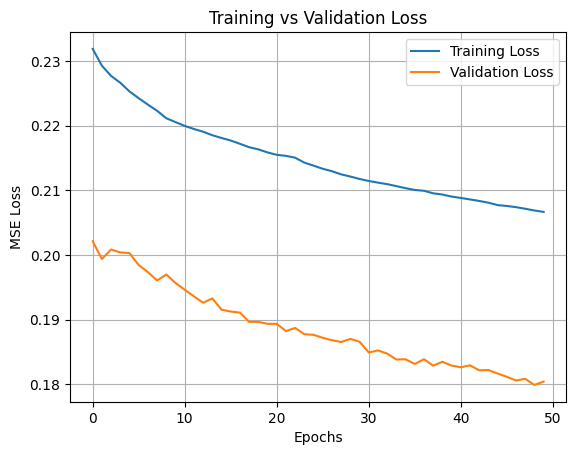

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

Normalization of other datasets

In [ ]:
TIME_STEPS = 10
cv_seq, cv_indices = create_sequences(cv_scaled, TIME_STEPS)
test_seq, test_indices = create_sequences(test_scaled, TIME_STEPS)

Calculating Reconstruction Errors:

In [ ]:
train_pred = autoencoder.predict(train_seq)
train_errors = np.mean(np.square(train_seq - train_pred), axis=(1, 2))

threshold = np.percentile(train_errors, 99.6)
print(f"Anomali eşik değeri (98. percentil): {threshold:.6f}")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step
Anomali eşik değeri (98. percentil): 0.338979


In [ ]:
cv_pred = autoencoder.predict(cv_seq)
test_pred = autoencoder.predict(test_seq)

cv_errors = np.mean(np.square(cv_seq - cv_pred), axis=(1, 2))
test_errors = np.mean(np.square(test_seq - test_pred), axis=(1, 2))


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [ ]:
cv_anomalies = cv_errors > threshold
test_anomalies = test_errors > threshold

print(f"Detected {np.sum(cv_anomalies)} anomalies out of {len(cv_errors)} CV sequences.")
print(f"Detected {np.sum(test_anomalies)} anomalies out of {len(test_errors)} test sequences.")

Detected 256 anomalies out of 19991 CV sequences.
Detected 209 anomalies out of 19991 test sequences.


In [ ]:
# Initialize predicted labels for each row as 0
cv_preds = np.zeros(len(df_cv_sorted))
test_preds = np.zeros(len(df_test_sorted))

# Mark rows that were the last point of an anomalous sequence as 1
for i, is_anomaly in zip(cv_indices, cv_anomalies):
    if is_anomaly:
        cv_preds[i] = 1

for i, is_anomaly in zip(test_indices, test_anomalies):
    if is_anomaly:
        test_preds[i] = 1

# True labels from your labeled datasets
cv_true = df_labeled_cv_sorted["Label"].values
test_true = df_labeled_test_sorted["Label"].values

# Evaluate performance
print("\nClassification Report (CV Set):")
print(classification_report(cv_true, cv_preds, digits=4))
print("Confusion Matrix (CV Set):")
print(confusion_matrix(cv_true, cv_preds))

print("\nClassification Report (Test Set):")
print(classification_report(test_true, test_preds, digits=4))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(test_true, test_preds))



Classification Report (CV Set):
              precision    recall  f1-score   support

           0     0.9886    0.9878    0.9882     19760
           1     0.0547    0.0583    0.0565       240

    accuracy                         0.9766     20000
   macro avg     0.5216    0.5230    0.5223     20000
weighted avg     0.9773    0.9766    0.9770     20000

Confusion Matrix (CV Set):
[[19518   242]
 [  226    14]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.9884    0.9900    0.9892     19759
           1     0.0574    0.0498    0.0533       241

    accuracy                         0.9787     20000
   macro avg     0.5229    0.5199    0.5213     20000
weighted avg     0.9772    0.9787    0.9780     20000

Confusion Matrix (Test Set):
[[19562   197]
 [  229    12]]


In [ ]:
cv_compare = df_labeled_cv_sorted[["ID", "UserID", "Label"]]
cv_compare["Predicted"] = cv_preds
cv_compare.head()
cv_compare.to_csv("cv_compare.csv", index=False)

<ipython-input-20-99fdda64816a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_compare["Predicted"] = cv_preds


In [ ]:
tst_compare = df_labeled_test_sorted[["ID", "UserID", "Label"]]
tst_compare["Predicted"] = test_preds
tst_compare.head()
tst_compare.to_csv("tst_compare.csv", index=False)

<ipython-input-21-aec36d9285e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_compare["Predicted"] = test_preds


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
import requests
import base64
from getpass import getpass

# 📌 Bilgileri gir
username = "sabisay"  # GitHub kullanıcı adın
token = getpass("GitHub Personal Access Token: ")  # Token gizli kalır
repo = "sabisay/AnomalyDetectionOnLogDatas"
branch = "main"
file_path = "/content/drive/MyDrive/Colab Notebooks/Anomaly_Detection_OnLogDatas_2025/LSTM_Autoencoder_SlidingWindow.ipynb"
commit_message = "📘 Notebook güncellendi - Colab üzerinden"

# 🔽 Dosya içeriğini oku
try:
    with open(file_path, "rb") as f:
        content = base64.b64encode(f.read()).decode()
except FileNotFoundError:
    raise Exception(f"{file_path} bulunamadı. Lütfen önce notebooku kaydet.")

# 🔍 GitHub'daki URL
# The URL was incorrect, it had an extra '/' before the file path. This has been corrected
url = f"https://api.github.com/repos/{repo}/contents/{file_path}"

# 🔐 Kimlik bilgileri
headers = {
    "Authorization": f"token {token}",
    "Content-Type": "application/json"
}

# ❓ Daha önce bu dosya yüklenmiş mi, bakalım
res = requests.get(url, headers=headers)
if res.status_code == 200:
    sha = res.json()["sha"]  # Güncelleme için gerekli
    print("📄 Dosya zaten mevcut, üstüne yazılacak.")
else:
    sha = None
    print("🆕 Dosya bulunamadı, yeni olarak yüklenecek.")

# 🚀 PUT isteği: Dosyayı GitHub'a yükle/güncelle
data = {
    "message": commit_message,
    "content": content,
    "branch": branch,
}
if sha:
    data["sha"] = sha

upload_res = requests.put(url, headers=headers, json=data)

# 🔚 Sonuç
if upload_res.status_code in [200, 201]:
    print("✅ Başarıyla GitHub'a yüklendi!")
else:
    # Print the error message instead of trying to call .json() if it failed
    print(f"❌ Hata: Status code {upload_res.status_code}, {upload_res.text}")

GitHub Personal Access Token: ··········
🆕 Dosya bulunamadı, yeni olarak yüklenecek.
❌ Hata: Status code 422, {"message":"path cannot start with a slash","errors":[{"resource":"Commit","field":"path","code":"invalid"}],"documentation_url":"https://docs.github.com/rest/repos/contents#create-or-update-file-contents","status":"422"}
